# [MNIST](https://en.wikipedia.org/wiki/MNIST_database) Digit Recognition Through Averages
stough 202-

In this notebook we'll define a simple linear scheme for recognizing hand-written digits. Every image we train on and ever test against is a $28\times28$ single-channel thumbnail. Look through [mnist_explore.ipynb](./mnist_explore.ipynb) for more. 

Our approach for recognizing the digit in a single image is simple: compare each pixel in the image against a template for each digit class. We'll do this through simple correlation: a dot-product of the image with the digit template. The higher the correlation, the higher the likelihood that the image is example of that template digit. 

In [1]:
%matplotlib inline
# or widget
import matplotlib.pyplot as plt

import numpy as np
from random import shuffle
import copy
import tempfile

from functools import partial
from multiprocessing.pool import ThreadPool

from torchvision import datasets, transforms
from torchvision.utils import make_grid

# For importing from alternative directory sources
import sys  
sys.path.insert(0, '../dip_utils')

from matrix_utils import (arr_info,
                          make_linmap)

## Loading and Formatting the MNIST Data

In [2]:
# Thank you: https://www.aiworkbox.com/lessons/load-mnist-dataset-from-pytorch-torchvision
# https://pytorch.org/docs/stable/torchvision/datasets.html
mnist_trainset = datasets.MNIST(root='/home/dip365/data', train=True, download=False, transform=None)
mnist_testset = datasets.MNIST(root='/home/dip365/data', train=False, download=False, transform=None)

x_train = np.stack([np.array(x).ravel() for x,_ in mnist_trainset])
x_test = np.stack([np.array(x).ravel() for x,_ in mnist_testset])
y_train = np.stack([y for _,y in mnist_trainset]).astype('long')
y_test = np.stack([y for _,y in mnist_testset]).astype('long')

# These are Nx784
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

In [3]:
arr_info(x_train)

((60000, 784), dtype('float32'), 0.0, 1.0)

In [4]:
d = x_train[10000]
arr_info(d)

((784,), dtype('float32'), 0.0, 1.0)

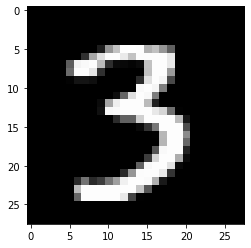

In [5]:
plt.figure()
plt.imshow(np.reshape(d,(28,28)), cmap='gray')
# Not normalized yet

In [6]:
#Different images has different sums, we want to normalize them

In [7]:
d.sum()

111.62744

In [8]:
x_train[400].sum()

125.29021

In [9]:
# Normalization -> square root of sum of the squares
d = d/np.sqrt((d*d).sum())

In [10]:
d.sum()

11.340133

In [11]:
np.sqrt(np.sum(d*d))
# Get a vector from 0 to 1. -- Divide it by itself to get back to 1

1.0

In [12]:
# Part2

In [13]:
arr_info(x_train)

((60000, 784), dtype('float32'), 0.0, 1.0)

In [14]:
arr_info(y_train)

((60000,), dtype('int64'), 0, 9)

## 0. Play around with all the data being provided.
As you see above, each row of `x_train` (or `x_test`) is a $784$-dimensional vector, just a flattened version of some $28\times28$ MNIST image in either the training or test data. Further, `y_train` (or `y_test`) contains the digit class. Explore these structures that have been provided, so that you will have some idea what in the world is happenning below.

- Visualize a corresponding row and element from `x_train` and `y_train`. 
  - What are the shapes of `x_train` and `y_train`? What about `x_test` and `y_test`?
  - Print out `y_train[1234]`
  - Try to visualize the corresponding hand-written digit image in `x_train`, that is `x_train[1234]` or `x_train[1234,:]`. Of course you cannot `imshow` a 1D row, so use [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).
  
Hopefully this exploration should convince you that we have training `x_train` and test `x_test` datasets, and these sets are also labeled through the arrays `y_train` and `y_test`. We're going to use the training data to formulate MNIST image templates for each digit, and then use the test data to see how well those templates generalize to data that we didn't use in training.  

In [15]:
y_train[1234]

3

## 1. Vector-normalize the `x_train` and `x_test` data.
[Normalize](https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy-to-a-unit-vector) each row so that every image has a magnitude of $1$. We want to do this so that when we do correlations/[dot-products](https://en.wikipedia.org/wiki/Dot_product), the possible outcomes are all values in the range normalized range $[-1,1]$. Use [`norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) and [`divide`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.divide.html) to pretty easily perform this normalization. 
If you're writing your own for loop, you haven't looked closely enough at the documentation for these powerfull numpy functions. 

- You may run into an issue with `broadcast` rules on division. For example, if we just look at the shapes $(10,3)$ and $(10,1)$, `divide` would know how to divide these two matrices: it would virtually make three vertical copies of the second so that the two shapes matched at $(10,3)$. However `divide` doesn't know what to do with $(10,3)$ and $(10,)$ for example, because the number of dimensions isn't even the same. Read the documentation and work with small examples to solve your issues.

In [16]:
## Check correctness, should be all True...
print(f'Is every row of x_test normalized?')
np.isclose(np.linalg.norm(x_test, axis=-1), 1.0)

Is every row of x_test normalized?


array([False, False, False, ..., False, False, False])

## 2. Compute a $10\times784$ matrix of template digits.
See [mnist_explore.ipynb](./mnist_explore.ipynb), where we compute the average seven for example. Do this for every digit using the `x_train` (and `y_train`) data. I call the resulting matrix `A` in the test cells.

In [17]:
arr_info(x_train)

((60000, 784), dtype('float32'), 0.0, 1.0)

In [18]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [19]:
arr_info(x_train[y_train == 0])

((5923, 784), dtype('float32'), 0.0, 1.0)

In [20]:
x_train[y_train == 0].mean(axis = 0).shape

(784,)

In [21]:
A = np.zeros((10,784))

In [22]:
for i in range(10): # Each of the 10 digits
    d = x_train[y_train == i].mean(axis=0)
    d = d/np.sqrt(np.sum(d*d))#Normalization
    A[i,:] = d

In [23]:
## Test norm, should be all True...
np.isclose(np.linalg.norm(A, axis=-1), 1.0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

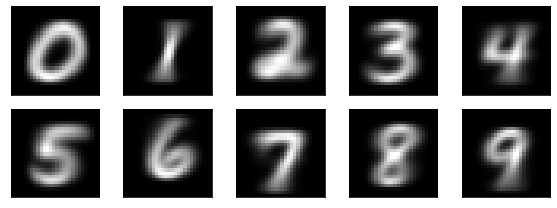

In [24]:
## Test sanity, visualize all the template digits
f, ax = plt.subplots(2,5, figsize=(8,3))
for i in range(5):
    ax[0, i].imshow(np.reshape(A[i,:], (28,28)), cmap='gray')
    ax[1, i].imshow(np.reshape(A[i+5,:], (28,28)), cmap='gray')

[a.axes.get_xaxis().set_visible(False) for a in ax.flatten()]
[a.axes.get_yaxis().set_visible(False) for a in ax.flatten()]
plt.tight_layout()

## 3. Correlate `x_test` against the template matrix.
Use [`matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) to compute the dot-product of every test case against every digit template. Given that there are 10K test images, our result should be $10000\times10$.

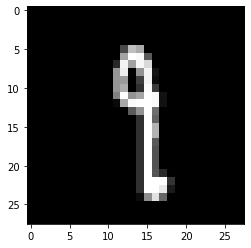

In [58]:
dt = x_test[4500]
plt.figure()
plt.imshow(np.reshape(d,(28,28)), cmap='gray')

In [59]:
# Want to know how close it is to the 10 digits

In [60]:
arr_info(dt)
dt = dt/np.sqrt(np.sum(dt*dt))

In [61]:
for i in range(10): # Loop through all 10 rows
    print(f'{i} score: {np.sqrt(np.sum((dt-A[i])*(dt-A[i])))}') # The score representing how close it is to each digits

0 score: 1.1555416899232218
1 score: 0.9479955463802177
2 score: 1.0909199421065099
3 score: 0.9549649237335066
4 score: 1.0899158838669805
5 score: 0.9795900948413719
6 score: 1.0812386686510194
7 score: 1.0215311662721318
8 score: 0.9659641660062614
9 score: 0.976482007477296


In [62]:
score_d = A@dt
score_d

array([0.3323617 , 0.55065228, 0.40494689, 0.54402102, 0.40604167,
       0.52020162, 0.41546146, 0.47823707, 0.53345664, 0.52324151])

In [68]:
np.argmin(score_d) # index of the min

0

In [64]:
np.argmax(score_d)

1

In [65]:
np.linalg.norm(x_test,axis=-1)[:,None].shape

(10000, 1)

In [66]:
x_test = x_test/np.linalg.norm(x_test,axis=-1)[:,None]

## 4. Compute the classification accuracy of this scheme.
Use [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to determine for each test case which template digit yielded the best score. Then compute the number that matched the correct labels from `y_test`. 

In [67]:
scores = A@x_test.transpose()
arr_info(scores)

((10, 10000), dtype('float64'), 0.117535573624724, 0.9517120577670922)

In [69]:
y_hat = np.argmax(scores, axis=0)

In [70]:
arr_info(y_hat)

((10000,), dtype('int64'), 0, 9)

In [71]:
arr_info(y_test)

((10000,), dtype('int64'), 0, 9)

In [73]:
np.sum(y_hat == y_test)

8216

## 5. Show some examples of the incorrectly-classified digit images from `x_test`
Remember you can use [`where`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to get the indices at which your `argmax` result above do not match the `y_test` labels.